<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_03_05_survival_analysis_generalized_gamma_model_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 3.5 Generalized Gamma Survival Model

Generalized Gamma Survival Model is a flexible parametric model that encompasses several common survival distributions as special cases. This tutorial provides an overview of the generalized gamma model, its properties, and how to implement it in Python using the `lifelines` library.

### Overview


The **Generalized Gamma (GG) survival model** is a highly flexible parametric model in survival analysis that generalizes several other models, including the exponential, Weibull, log-normal, and gamma distributions. It is characterized by three parameters, allowing it to model a wide range of hazard shapes (monotonic increasing, decreasing, arc-shaped, or bathtub-shaped). This makes it suitable for complex survival data where simpler models (e.g., exponential or log-normal) may not fit well. The GG model can be used in an Accelerated Failure Time (AFT) framework, where covariates scale the survival time, or in other parameterizations depending on the software.


### Key Features


- **Flexibility**: The GG model’s three parameters allow it to capture diverse hazard behaviors, including those of the exponential ($p = q = 1$), Weibull ($q = 1$), log-normal ($q\to \infty$), and standard gamma ($p = q$).
- **Applications**: Used in medical research (e.g., survival after treatment), reliability engineering (e.g., component failure times), and economics (e.g., duration models) when hazard shapes are complex or unknown.
- **Assumptions**: Assumes survival times $T$ follow a generalized gamma distribution, with log-times having a flexible distribution controlled by shape parameters.
- **Advantages**: Encompasses multiple models, reducing the need to test several distributions. Can model non-monotonic hazards (e.g., bathtub-shaped for infant mortality followed by aging).
- **Limitations**: Computationally intensive due to three parameters. Parameter estimation can be unstable with small datasets or misspecified models. Less intuitive interpretation compared to simpler models.


The generalized gamma distribution has three parameters: $\mu$ (location, related to the mean of log-time), $\sigma > 0$ (scale, controlling dispersion), and $q$ (shape, affecting hazard shape). Alternatively, it is often parameterized with a scale parameter $\lambda = \exp(-\mu/\sigma)$ and shape parameters $p = 1/(\sigma q).

- **Probability Density Function (PDF)**:
$$
  f(t) = \frac{p \lambda (p t)^{pq - 1} e^{-(p t)^q}}{\Gamma(p)}, \quad t > 0, \quad \lambda, p, q > 0
$$

where $\Gamma$ is the gamma function, $p = 1/(\sigma q)$, and $\lambda = \exp(-\mu/\sigma)$. The PDF is complex but reduces to simpler forms (e.g., Weibull when $q = 1$).

- **Survival Function**:

$$
  S(t) = 1 - \frac{\gamma(p, (p t)^q)}{\Gamma(p)}
$$

 where $\gamma(p, x) = \int_0^x u^{p-1} e^{-u} \, du $ is the incomplete gamma function. This gives the probability of surviving past time $t$.

- **Hazard Function**:

$$
  h(t) = \frac{f(t)}{S(t)} = \frac{p \lambda (p t)^{pq - 1} e^{-(p t)^q}}{\Gamma(p) - \gamma(p, (p t)^q)}
$$
  The hazard shape depends on $p$ and $q$:
  
  - $p > 1, q > 1$: Arc-shaped (increases then decreases).
  - $p < 1, q < 1$: Bathtub-shaped (decreases, then increases).
  - $q = 1$: Weibull-like (monotonic increasing or decreasing).

- **Mean and Variance**:

  - Mean: $E[T] = \frac{\exp(\mu) \Gamma(p + 1/q)}{\Gamma(p)}$, if $p + 1/q > 0$.
  - Variance: Complex, involving higher-order gamma functions.
  - Note: Mean may be undefined for certain parameter values.


### When to Use


Choose the generalized gamma model when:
- Nonparametric hazard estimates (e.g., from Kaplan-Meier) show complex shapes (arc-shaped, bathtub-shaped, or non-monotonic).
- You want to test multiple parametric models within one framework (e.g., exponential, Weibull, log-normal).
- Flexibility is needed, but you’re willing to handle computational complexity.


### Model Fit Assessment


- Use AIC/BIC to compare with simpler models (e.g., Weibull, log-normal, log-logistic).
- Check residuals (e.g., Cox-Snell) or compare fitted survival curves to Kaplan-Meier estimates.
- Validate parameter estimates with Q-Q plots or hazard shape diagnostics.


## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
Installing lifelines...
lifelines installed successfully
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ lifelines


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import GeneralizedGammaFitter, WeibullFitter, WeibullAFTFitter
from lifelines.utils import concordance_index
from lifelines.plotting import add_at_risk_counts

In [4]:
!pip install scikit-survival>=0.23

## Implementation in Python

### Data Loading and Cleaning

In [7]:
# Load data
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
df = pd.read_csv(url)

# Recode variables (corrected: status=2 means dead, per original R code)
df['sex'] = df['sex'].map({1: 0, 2: 1})           # 0 = male, 1 = female
df['event'] = (df['status'] == 2).astype(int)     # status=2 means dead (event=1); status=1 is censored

# Clean dataset: drop rows with missing key covariates
df_clean = df.dropna(subset=['time', 'age', 'sex', 'ph.ecog', 'wt.loss']).copy()

# Center age for numerical stability and interpretability
df_clean['age_centered'] = df_clean['age'] - df_clean['age'].mean()

print(f"Final dataset size: {len(df_clean)} observations")
print(f"Events: {df_clean['event'].sum()} ({df_clean['event'].mean():.1%} of total)")
print(df_clean[['time', 'event', 'age', 'age_centered', 'sex', 'ph.ecog', 'wt.loss']].head())

Final dataset size: 213 observations
Events: 151 (70.9% of total)
   time  event  age  age_centered  sex  ph.ecog  wt.loss
1   455      1   68      5.497653    0      0.0     15.0
2  1010      0   56     -6.502347    0      0.0     15.0
3   210      1   57     -5.502347    0      1.0     11.0
4   883      1   60     -2.502347    0      0.0      0.0
5  1022      0   74     11.497653    0      1.0      0.0


### Kaplan-Meier Non-Parametric Estimate

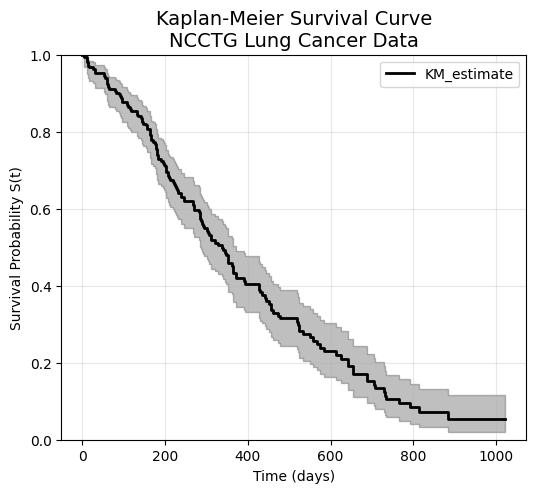

In [9]:
from lifelines import KaplanMeierFitter

# Kaplan-Meier curve
kmf = KaplanMeierFitter()

plt.figure(figsize=(6, 5))
kmf.fit(durations=df_clean['time'], event_observed=df_clean['event'])
kmf.plot_survival_function(ci_show=True, color='black', linewidth=2)

plt.title('Kaplan-Meier Survival Curve\nNCCTG Lung Cancer Data', fontsize=14)
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability S(t)')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

### Fit a Generalized Gamma Model (Univariate)

First, we fit a model without covariates (just to understand the baseline distribution).

<lifelines.GeneralizedGammaFitter:"GeneralizedGamma_estimate", fitted with 228 total observations, 63 right-censored observations>
   number of observations = 228
number of events observed = 165
           log-likelihood = -1153.69
               hypothesis = mu_ != 0, ln_sigma_ != 0, lambda_ != 1

---
           coef  se(coef)  coef lower 95%  coef upper 95%
mu_        6.08      0.09            5.89            6.26
ln_sigma_ -0.32      0.10           -0.52           -0.12
lambda_    1.13      0.23            0.68            1.58

           cmp to     z      p  -log2(p)
mu_          0.00 64.47 <0.005       inf
ln_sigma_    0.00 -3.17 <0.005      9.38
lambda_      1.00  0.55   0.58      0.78
---
AIC = 2313.38

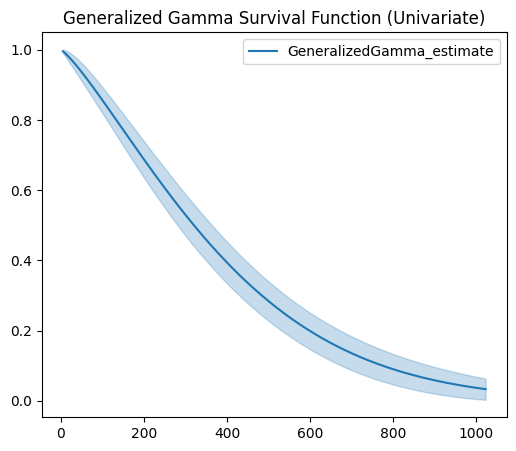

In [10]:
# Initialize fitter
ggf = GeneralizedGammaFitter()

# Fit model
ggf.fit(durations=df['time'], event_observed=df['event'])

# Print summary
ggf.print_summary()

# Plot survival function
plt.figure(figsize=(6, 5))
ggf.plot_survival_function()
plt.title('Generalized Gamma Survival Function (Univariate)')
plt.show()

The Generalized Gamma distribution has three parameters:

- `mu` (location)
- `sigma` (scale)
- `lambd`a (shape)

### Compare with Weibull (Nested Model)

In [11]:
wf = WeibullFitter()
wf.fit(df['time'], df['event'])

# Compare log-likelihoods
print(f"Generalized Gamma log-likelihood: {ggf.log_likelihood_:.2f}")
print(f"Weibull log-likelihood: {wf.log_likelihood_:.2f}")

# AIC
print(f"GG AIC: {-2*ggf.log_likelihood_ + 2*3:.2f}")
print(f"Weibull AIC: {-2*wf.log_likelihood_ + 2*2:.2f}")


Generalized Gamma log-likelihood: -1153.69
Weibull log-likelihood: -1153.85
GG AIC: 2313.38
Weibull AIC: 2311.70


###  Fit Generalized Gamma AFT Model with Covariates

Now include predictors like age, sex, and ph.ecog (if available).

AFT Interpretation:

* If `coef < 0` → increases survival time (protective)
* If `coef > 0` → decreases survival time (harmful)
* Effects are multiplicative on time


Since Generalized Gamma AFT isn’t available, choose a flexible alternative like Weibull or Log-Normal, which are special cases of the Generalized Gamma.

<lifelines.WeibullAFTFitter: fitted with 227 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'event'
   number of observations = 227
number of events observed = 164
           log-likelihood = -1132.44
         time fit was run = 2026-01-08 21:03:22 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ Intercept  6.67    791.96      0.43            5.84            7.51              342.69             1830.24
        age       -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
        sex        0.40      1.49      0.12            0.16            0.64                1.17                1.90
        ph.ecog   -0.34      0.71      0.08           -0.50           -0.18                0.60                0.84
rho_    Intercept  0.31      1.37      0.06            0.19            0.43                1.21                1.54

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ Intercept    0.00 15.62 <0.005    180.22
        age          0.00 -1.11   0.27      1.89
        sex          0.00  3.24 <0.005      9.72
        ph.ecog      0.00 -4.07 <0.005     14.37
rho_    Intercept    0.00  5.11 <0.005     21.53
---
Concordance = 0.64
AIC = 2274.88
log-likelihood ratio test = 29.98 on 3 df
-log2(p) of ll-ratio test = 19.45

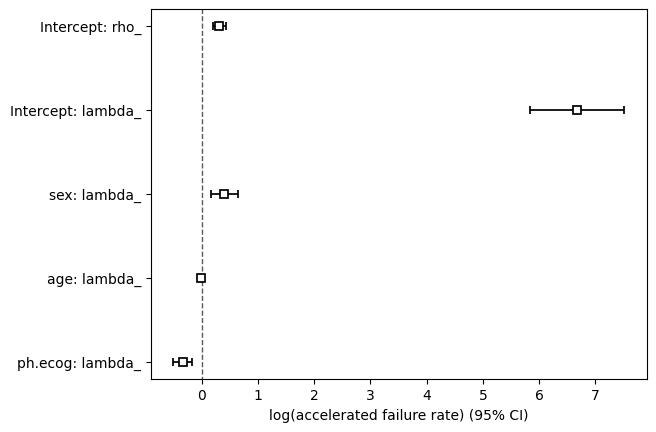

In [15]:
# Prepare event indicator (assuming status == 2 means death)
df['event'] = df['status'] == 2

# Select covariates (adjust based on actual columns)
covariates = ['age', 'sex', 'ph.ecog']
df_clean = df.dropna(subset=covariates + ['time', 'event']).copy()

# Fit Weibull AFT model
aft = WeibullAFTFitter()
aft.fit(df_clean, duration_col='time', event_col='event', formula=" + ".join(covariates))

# Results
aft.print_summary()

# Plot
aft.plot()
plt.show()

### Survival Probability

In [16]:
# Predict median survival times
df_clean['predicted_median'] = aft.predict_median(df_clean[covariates])

# Compute concordance index
ci = concordance_index(
    event_times=df_clean['time'],
    predicted_scores=df_clean['predicted_median'],
    event_observed=df_clean['event']
)
print(f"Concordance Index: {ci:.3f}")

Concordance Index: 0.637


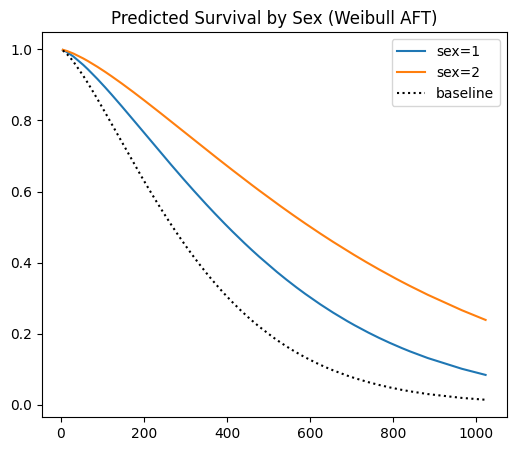

In [17]:
# plot surviavl probablity
fig, ax = plt.subplots(figsize=(6, 5))
aft.plot_partial_effects_on_outcome('sex', [1, 2], ax=ax)
plt.title('Predicted Survival by Sex (Weibull AFT)')
plt.show()

## Coustom Implementation of Generalized Gamma AFT

While `lifelines` does include `GeneralizedGammaFitter` for univariate (no-covariate) fitting, it does not provide a built-in Generalized Gamma AFT regression model with covariates.

However, we can implement a Generalized Gamma Accelerated Failure Time (AFT) model with covariates by maximizing its log-likelihood using numerical optimization (e.g., via scipy.optimize). This is a common approach in survival analysis when flexible parametric models are needed.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln, gammaincc, gammaincinv
from lifelines.utils import concordance_index

def generalized_gamma_aft_fit(df, duration_col, event_col, covariates):
    """
    Fit Generalized Gamma AFT model with covariates.
    Returns a model object dict with prediction methods.
    """
    T = df[duration_col].values
    E = df[event_col].astype(int).values
    X = df[covariates].values
    n, p = X.shape

    if np.any(T <= 0):
        raise ValueError("Survival times must be > 0.")

    logT = np.log(T)

    # Initial beta: OLS on uncensored
    uncensored = E == 1
    if np.sum(uncensored) >= p:
        from sklearn.linear_model import LinearRegression
        beta_init = LinearRegression().fit(X[uncensored], logT[uncensored]).coef_
    else:
        beta_init = np.zeros(p)

    residuals = logT - X @ beta_init
    sigma_init = max(np.std(residuals), 1e-3)
    init_params = np.concatenate([beta_init, [np.log(sigma_init), 1.0]])

    def neg_log_likelihood(params):
        beta = params[:p]
        log_sigma = params[p]
        Q = params[p + 1]
        sigma = np.exp(log_sigma)
        z = (logT - X @ beta) / sigma
        Qz = Q * z
        Q2 = Q * Q
        inv_Q2 = 1.0 / Q2

        # Log PDF (events)
        log_f = (
            np.log(np.abs(Q)) - log_sigma - logT - gammaln(inv_Q2) +
            (inv_Q2 - 1) * Qz - Q2 * np.exp(Qz)
        )

        # Log survival (censored)
        a = inv_Q2
        x = Q2 * np.exp(Qz)
        log_S = np.where(
            Q >= 0,
            np.log(gammaincc(a, x) + 1e-16),
            np.log(1.0 - gammaincc(a, x) + 1e-16)
        )

        log_f = np.nan_to_num(log_f, nan=-1e10)
        log_S = np.nan_to_num(log_S, nan=-1e10)

        return -(np.sum(E * log_f + (1 - E) * log_S))

    result = minimize(neg_log_likelihood, init_params, method='L-BFGS-B')
    if not result.success:
        print("Warning: Optimization may not have converged.")

    beta = result.x[:p]
    sigma = np.exp(result.x[p])
    Q = result.x[p + 1]

    # --- Enhanced return object with methods ---
    model = {
        'beta': beta,
        'sigma': sigma,
        'Q': Q,
        'covariates': covariates,
        'converged': result.success,
        'log_likelihood': -result.fun
    }

    def predict_median(X_new):
        X_new = np.atleast_2d(X_new)
        linear_pred = X_new @ beta
        a = 1.0 / (Q * Q)
        if Q > 0:
            x_med = gammaincinv(a, 0.5)
            w_med = (np.log(x_med) - np.log(Q * Q)) / Q
        else:
            x_med = gammaincinv(a, 0.5)
            w_med = (np.log(x_med) - np.log(Q * Q)) / Q
        return np.exp(linear_pred + sigma * w_med)

    def predict_survival_function(X_new, times):
        """
        Return survival probabilities S(t) for given X and times.
        """
        X_new = np.atleast_2d(X_new)  # shape (n_samples, p)
        times = np.atleast_1d(times)
        n_samples = X_new.shape[0]
        n_times = len(times)
        S = np.zeros((n_samples, n_times))

        linear_pred = X_new @ beta  # shape (n_samples,)
        log_times = np.log(times)   # shape (n_times,)

        for i in range(n_samples):
            z = (log_times - linear_pred[i]) / sigma  # broadcast over times
            Qz = Q * z
            x = (Q * Q) * np.exp(Qz)
            a = 1.0 / (Q * Q)
            if Q >= 0:
                S[i, :] = gammaincc(a, x)
            else:
                S[i, :] = 1.0 - gammaincc(a, x)
        S = np.clip(S, 0, 1)
        return S

    model['predict_median'] = predict_median
    model['predict_survival_function'] = predict_survival_function
    return model

In [19]:
# Load and prepare data
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
df = pd.read_csv(url)
df['sex'] = df['sex'].map({1: 0, 2: 1})
df['event'] = (df['status'] == 2).astype(int)
df_clean = df.dropna(subset=['time', 'age', 'sex', 'ph.ecog', 'wt.loss']).copy()
df_clean['age_centered'] = df_clean['age'] - df_clean['age'].mean()


### Fit Model & Predict Median Survival

In [20]:
covariates = ['age_centered', 'sex', 'ph.ecog', 'wt.loss']
gg_aft = generalized_gamma_aft_fit(df_clean, 'time', 'event', covariates)

# Predict median survival for each patient
df_clean['predicted_median'] = gg_aft['predict_median'](df_clean[covariates].values)

# Compute concordance index
ci = concordance_index(
    event_times=df_clean['time'],
    predicted_scores=df_clean['predicted_median'],  # higher = longer survival (AFT)
    event_observed=df_clean['event']
)
print(f"Concordance Index: {ci:.3f}")

Concordance Index: 0.534


/tmp/ipython-input-3363181251.py:48: RuntimeWarning: overflow encountered in exp
  (inv_Q2 - 1) * Qz - Q2 * np.exp(Qz)
/tmp/ipython-input-3363181251.py:53: RuntimeWarning: overflow encountered in exp
  x = Q2 * np.exp(Qz)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### Plot Survival by Sex

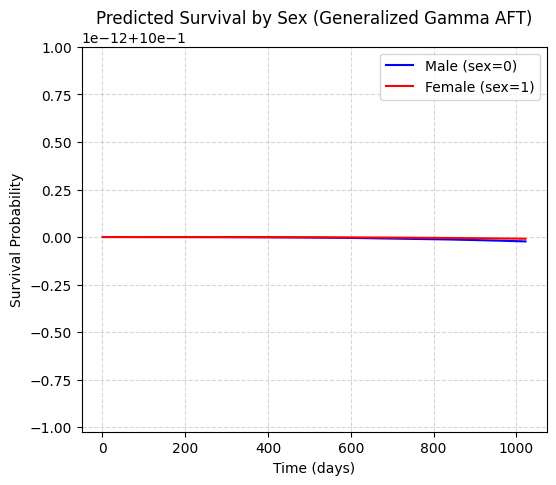

In [21]:
# Create reference profiles
ref_male = pd.DataFrame({
    'age_centered': [0],
    'sex': [0],
    'ph.ecog': [df_clean['ph.ecog'].median()],
    'wt.loss': [df_clean['wt.loss'].median()]
})

ref_female = ref_male.copy()
ref_female['sex'] = 1

# Combine
X_plot = pd.concat([ref_male, ref_female], ignore_index=True)

# Time points for plotting
times = np.linspace(1, df_clean['time'].max(), 200)

# Predict survival
S = gg_aft['predict_survival_function'](X_plot.values, times)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(times, S[0], label='Male (sex=0)', color='blue')
ax.plot(times, S[1], label='Female (sex=1)', color='red')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')
ax.set_title('Predicted Survival by Sex (Generalized Gamma AFT)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Summary and Conclusion


The generalized gamma survival model is a powerful and flexible tool in survival analysis, capable of modeling a wide range of hazard shapes through its three parameters. It encompasses several common distributions, making it a versatile choice when the underlying hazard function is complex or unknown. However, its complexity can lead to computational challenges and interpretability issues, especially with small datasets. Model fit should be carefully assessed using AIC/BIC, residual analysis, and visual diagnostics to ensure the chosen model adequately represents the data.


## Resources


1. lifelines documentation: https://lifelines.readthedocs.io

2. Lawless, J. F. (1980). Inference in the Generalized Gamma and Log-Gamma Distributions.

3. Cox, D. R. (1972). Regression Models and Life-Tables.
